**Particle Filter Algorithm**

1. (sim) initialise pokemon positions
2. get initial pokemon distance level and rankings
3. create random particles for each pokemon on radar
4. assign selection probabilities to each particle based on the respective distance levels and rankings of that pokemon
5. resample the particle population of each pokemon based on the selection probabilities obtained in step 4
6. calculate the weighed average location of target pokemon
7. start moving in the direction of the weighed average location of target pokemon
8. listen for distance level or ranking change events. On event, halt moving and:
    1. re-calculate particle selection probabilities of affected pokemon(s)
    2. resample the particle population of affected pokemon(s)
    3. re-calculate weighed average location of target pokemon
    4. start moving in the direction obtained in the previous step and resume listening for events
9. program terminates when the target pokemon is within zero-footprint distance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from scipy.stats import gennorm
from scipy.stats import gamma
%matplotlib inline

In [8]:
def generate_initial_coordinates(side_length=2000, n_pokemon=9):
    pokemons = {}
    for i in range(n_pokemon):
        pokemons[i] = (random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2))
    return pokemons

def distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# this is not visible to players
def pokemon_distances(player_coord, pokemons):
    return {i: distance(player_coord, coord) for i, coord in pokemons.items()}

def get_particle_distances(player_coord, particles):
    return [distance(player_coord, particle) for particle in particles]

def rank(input):
    output = [0] * len(input)
    for i, x in enumerate(sorted(range(len(input)), key=lambda y: input[y])):
        output[x] = i
    return output

# player will be able to see this
def pokemon_rankings(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    rankings = {}
    for i, x in enumerate(sorted(range(len(dists)), key=lambda y: dists[y])):
        rankings[x] = i
    return rankings

def plot_pokemons(player_coord, pokemons):
    plt.figure(figsize=(15,15))
    # non-target pokemons
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][1:], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][1:])
    # target pokemon
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][0], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][0],
               marker="*", color='red', s=15)
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()
    
def footprint(distance):
    if distance < 10:
        return 0
    elif distance < 25:
        return 1
    elif distance < 100:
        return 2
    elif distance < 1000:
        return 3
    else:
        return np.nan

def footprint_counts(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    return {i: footprint(v) for i,v in dists.items()}

def random_particle_generation(side_length=2000, n=1000):
    particles = [0] * n
    for i in range(n):
        particles[i] = (random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2))
    return particles

def plot_particles(player_coord, particles):
    plt.figure(figsize=(15,15))
    plt.scatter([p[0] - player_coord[0] for p in particles], 
                [p[1] - player_coord[1] for p in particles])
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()

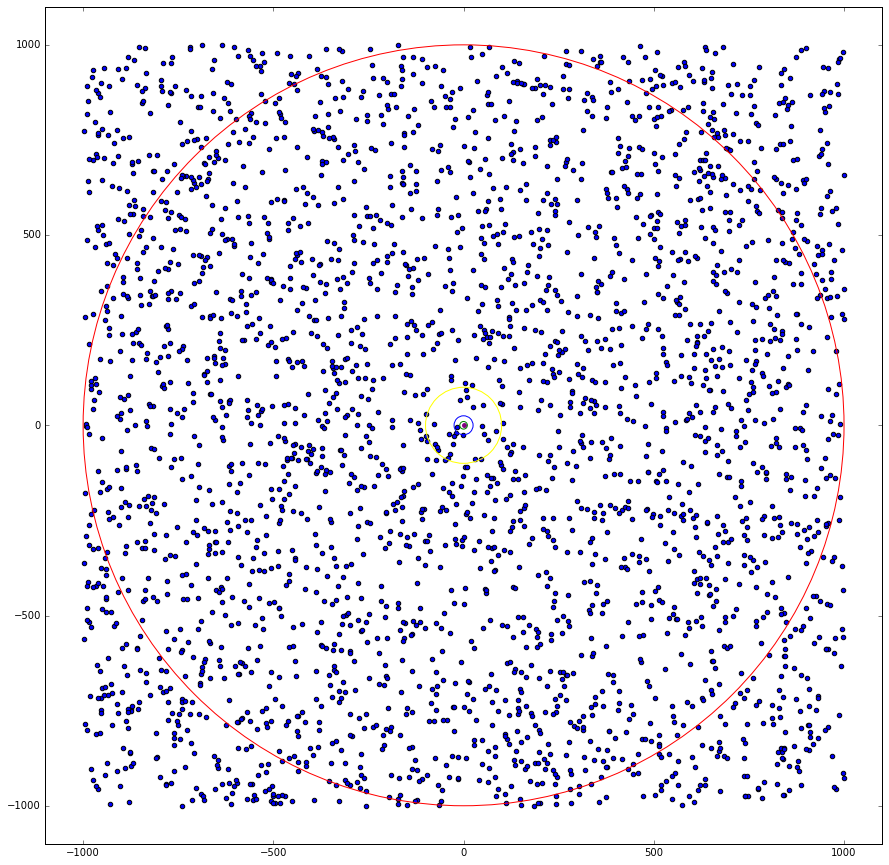

In [4]:
particles = random_particle_generation(n=3000)
plot_particles((0, 0), particles)

Another source of information we might want to exploit is the true ranking and probability of a particular particle being consistent with the ranking.

Let A, B denote two pokemons. Let A[i] denote a particle of pokemon A and B[j] a paricle of pokemon B. There are other pokemons C, D, E...

The probability that A[i] is consistent with a particular ranking (say B>A>C>...) is:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C | B>A[i]) * P(A[i]>D | A[i]>C, B>A[i]) * ...

(Option 1) Using the naive approach, we have:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C) * P(A[i]>D) * ...

(Option 2) Assuming the order of other particles are fixed, then the probability can be obtained by only considering immediately neighbouring pokemons, since the other conditional probabilities will be 1.

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C | B>A[i])

Now use the naive assumption:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C)

We may calculate, say P(A[i]>C), as follows:

    P(A[i]>C) = sum{P(A[i]>C[j]) * P(C[j])} over all j

P(A[i]>C[j]) is either 1 or 0 depending on the relationship between the distance of A[i] and C[j].

So the probability of a particle being consistent with the true ranking is:

    L(A[i]) = sum{P(A[i]<B[j]) * P(B[j])} * sum{P(A[i]>C[j]) * P(C[j])}
   
Now we have a probability associated with each particle for a given pokemon with which we can perform the resampling.

Whenever an event occurs and the some particles are resampled, we can perform this operation on the particle populations to favour those particles that are more likely to be consistent with the ranking.

In [15]:
distributions = {
    0: lambda x: gennorm.pdf(x / 10, 3),
    1: lambda x: gennorm.pdf((x - 17.5) / 7.5, 3),
    2: lambda x: gennorm.pdf((x - 62.5) / 37.5, 4),
    3: lambda x: gennorm.pdf((x - 550) / 430, 6),
    'in': lambda x: gamma.pdf((-x + 1100) / (450/6), 1.5),
    'out': lambda x: gamma.pdf((x - 900) / (450/6), 1.5)
}

def resample_population(particles, particle_weights):
    return [particles[np.random.choice(range(len(particles)), p=particle_weights / sum(particle_weights))] 
            for i in range(len(particles))]

def distance_level_weights(particle_distances, distance_level, distributions=distributions):
    particle_weights = list(map(distributions[distance_level], particle_distances))
    return particle_weights

def all_ranking_weights(all_particle_distances, rankings):
    return {}

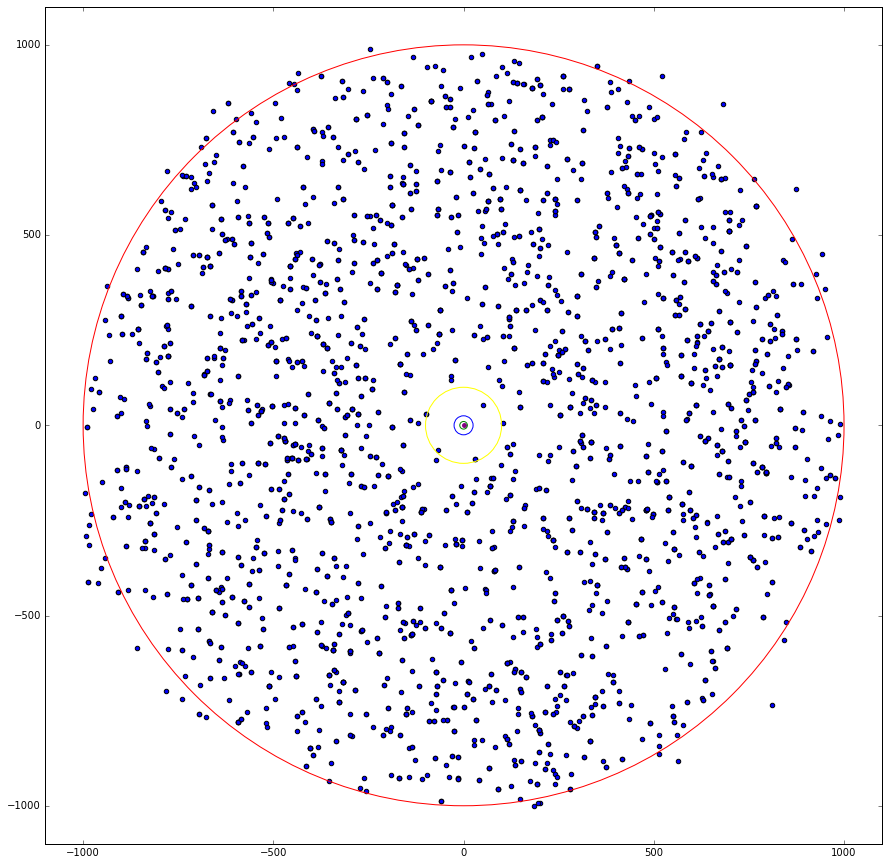

In [20]:
new_particles = resample_population(particles, distance_level_weights(get_particle_distances((0, 0), particles), 3))
plot_particles((0, 0), new_particles)